<a href="https://colab.research.google.com/github/AG-Sign/Modulation-Classification/blob/main/Modulation_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Dataset

**Imports**

In [ ]:
import numpy as np
import _pickle as cPickle
from itertools import repeat
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras import models
from tensorflow.python.framework import ops
from sklearn.model_selection import train_test_split
import gc
from tensorflow import keras 
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Reshape, Flatten
from keras import metrics

from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

**Google drive mount**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
filename = "/content/drive/MyDrive/Modulation Classification/Dataset/RML2016.10b.da"
open_file = open(filename,'rb')
data = cPickle.load(open_file, encoding='latin1')

In [ ]:
print(data)

**Extract raw features**

In [ ]:
keys_list = list(data.keys())

In [ ]:
X = []
for current in keys_list:
  X.extend(data[current[0],current[1]])

In [ ]:
del(data)

In [ ]:
#make X (1200000,2,129)
X_0 = [] 
for x in (X):
  first_func = x[0]
  second_func = x[1]
  #add zero to make size like integration
  first_func = np.concatenate([[0], np.array(first_func)])
  second_func = np.concatenate([[0], np.array(second_func)])
  arr = []
  arr.append(first_func)
  arr.append(second_func)
  X_0.append(arr)

In [ ]:
derivative_01 = []  # for raw data 
for x in (X):
  first_func = x[0]
  second_func = x[1]
  p1 = np.poly1d(first_func)
  d1 = np.polyder(p1)
  p2 = np.poly1d(second_func)
  d2 = np.polyder(p2)
  
  #add zero to make size like input
  first_func_derivative = np.concatenate([[0], np.array(d1)])
  second_func_derivative = np.concatenate([[0], np.array(d2)])
  arr = []
  arr.append(first_func_derivative)
  arr.append(second_func_derivative)
  derivative_01.append(arr)
# derivative = np.array(derivative_01)
# print(derivative.shape)

In [ ]:
derivative_10 = []  # for combination data 
for x in (X):
  first_func = x[0]
  second_func = x[1]
  p1 = np.poly1d(first_func)
  d1 = np.polyder(p1)
  p2 = np.poly1d(second_func)
  d2 = np.polyder(p2)
  
  #add zero to make size like input
  first_func_derivative = np.concatenate([[0,0], np.array(d1)])
  second_func_derivative = np.concatenate([[0,0], np.array(d2)])
  arr = []
  arr.append(first_func_derivative)
  arr.append(second_func_derivative)
  derivative_10.append(arr)
# derivative = np.array(derivative_01)
# print(derivative.shape)

In [ ]:
integration = []
for x in (X):
  first_func = x[0]
  second_func = x[1]
  p1 = np.poly1d(first_func)
  I1 = np.polyint(p1)
  p2 = np.poly1d(second_func)
  I2 = np.polyint(p2)
  
  first_func_integration =  np.array(I1)
  second_func_integration = np.array(I2)
  arr = []
  arr.append(first_func_integration)
  arr.append(second_func_integration)
  integration.append(arr)
# integration = np.array(integration)
# print(integration.shape)

In [ ]:
del(first_func)
del(second_func)
del(p1)
del(p2)
del(arr)

In [ ]:
del(d2)
del(d1)
del(first_func_derivative)
del(second_func_derivative)

In [ ]:
del(I1)
del(I2)
del(first_func_integration)
del(second_func_integration)

In [ ]:
def conc(arr1, arr2):
  for i in range(len(arr2)):
    arr1[i].append(arr2[i][0])
    arr1[i].append(arr2[i][1])
  return arr1

In [ ]:
X_conc = conc(derivative_01,X)
del(derivative_01)
del(X)

In [ ]:
del(X)
X_conc = conc(derivative_10,integration)
del(derivative_10)
del(integration)

In [ ]:
del(X)
X_conc = conc(integration,X_0)
del(integration)
del(X_0)

In [ ]:
X_conc = conc(derivative_10,integration)
del(derivative_10)
del(integration)
X_conc = conc(X_conc,X_0)
del(X)

In [ ]:
print(len(X_conc[0]))

4


In [ ]:
Y = []
for current in keys_list:
  #Y.extend(repeat(current[0],6000))
  Y.extend(repeat(current,6000))

In [ ]:
gc.collect()

440

# Model

In [ ]:
labels_map = {
    "8PSK": 0,
     "AM-DSB": 1,
     "AM-SSB": 2,
     "BPSK": 3,
     "CPFSK": 4,
     "GFSK": 5,
     "PAM4": 6,
     "QAM16": 7,
     "QAM64": 8,
     "QPSK": 9,
     "WBFM": 10
}

def mapper(element):
  return labels_map[element]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_conc, Y, test_size=0.3,random_state=5,stratify=Y)
del(X_conc)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.05,random_state=5,stratify=y_train)

In [ ]:
X_vtrain, X_vval, y_vtrain, y_vval = train_test_split(X_val, y_val, test_size=0.05,random_state=5,stratify=y_val)

In [ ]:
def split_y(y):
  y_label = []
  snr = []
  for element in (y):
    y_label.append(element[0])
    snr.append(element[1])
  return y_label, snr

In [ ]:
y_train , SNR_train = split_y(y_train)
y_train = map(mapper,y_train)
y_train = list(y_train)
y_train = np.array(y_train)
temp = np.zeros((y_train.size, 11))
temp[np.arange(y_train.size),y_train] = 1
y_train = temp

y_val , SNR_val = split_y(y_val)
y_val = map(mapper,y_val)
y_val = list(y_val)
y_val = np.array(y_val)
temp2 = np.zeros((y_val.size, 11))
temp2[np.arange(y_val.size),y_val] = 1
y_val = temp2

y_test , SNR_test = split_y(y_test)
y_test = map(mapper,y_test)
y_test = list(y_test)
y_test = np.array(y_test)
temp3 = np.zeros((y_test.size, 11))
temp3[np.arange(y_test.size),y_test] = 1
y_test = temp3

In [ ]:
print(y_train.shape)

(798000, 11)


In [ ]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

In [ ]:
del(temp)
del(temp2)
del(temp3)
# del(X_train)
# del(y_train)

##CNN

In [ ]:
def convolutional_model(input_shape):

    input_img = tf.keras.Input(shape=input_shape)


    Z1 = tfl.Conv2D(64, (1,3), activation='relu', strides=1)(input_img)
    Z2 = tfl.Conv2D(16, (2,3), activation='relu', strides=1)(Z1)

    B = tfl.BatchNormalization()(Z2)

    F = tfl.Flatten()(B)

    D1 = tfl.Dense(128, activation='relu')(F)

    DR = tfl.Dropout(0.5)(D1)

    outputs = tfl.Dense(11, activation='softmax')(DR)
    
    # YOUR CODE ENDS HERE
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

In [ ]:
conv_model = convolutional_model((4, 128, 1))
conv_model.compile(optimizer= keras.optimizers.Adam(learning_rate = 0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

conv_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 128, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 4, 126, 64)        256       
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 124, 16)        6160      
                                                                 
 batch_normalization (BatchN  (None, 3, 124, 16)       64        
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 5952)              0         
                                                                 
 dense (Dense)               (None, 128)               761984    
                                                             

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64)
validation_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(64)

In [ ]:
del(X_train)
del(y_train)
del(X_val)
del(y_val)

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/Pattern (1)/Lab 4/CNN checkpoints/checkpoint_der_x_2'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
history = conv_model.fit(train_dataset, epochs=15, validation_data=validation_dataset, callbacks=[model_checkpoint_callback])

Epoch 1/15
12469/12469 [==============================] - 77s 5ms/step - loss: 1.4919 - accuracy: 0.3846 - val_loss: 1.2850 - val_accuracy: 0.4682
Epoch 2/15
12469/12469 [==============================] - 64s 5ms/step - loss: 1.3362 - accuracy: 0.4477 - val_loss: 1.2161 - val_accuracy: 0.4974
Epoch 3/15
12469/12469 [==============================] - 64s 5ms/step - loss: 1.2973 - accuracy: 0.4633 - val_loss: 1.1978 - val_accuracy: 0.5074
Epoch 4/15
12469/12469 [==============================] - 64s 5ms/step - loss: 1.2750 - accuracy: 0.4731 - val_loss: 1.1943 - val_accuracy: 0.5072
Epoch 5/15
12469/12469 [==============================] - 64s 5ms/step - loss: 1.2612 - accuracy: 0.4774 - val_loss: 1.1742 - val_accuracy: 0.5132
Epoch 6/15
12469/12469 [==============================] - 63s 5ms/step - loss: 1.2523 - accuracy: 0.4806 - val_loss: 1.1902 - val_accuracy: 0.5100
Epoch 7/15
12469/12469 [==============================] - 63s 5ms/step - loss: 1.2454 - accuracy: 0.4838 - val_loss: 1

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Epoch')]

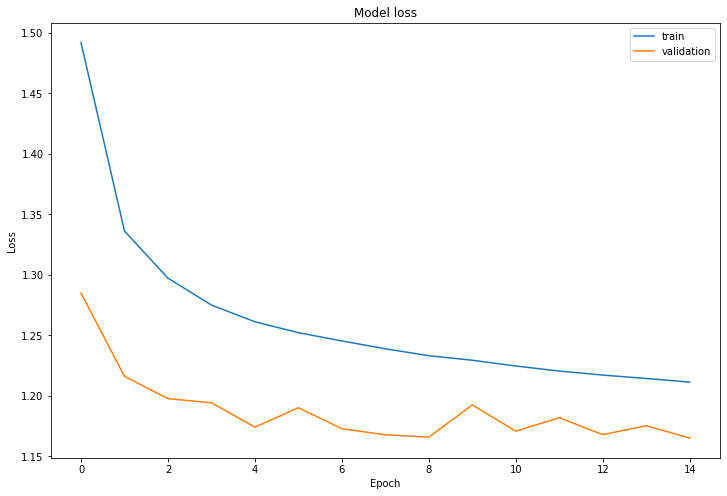

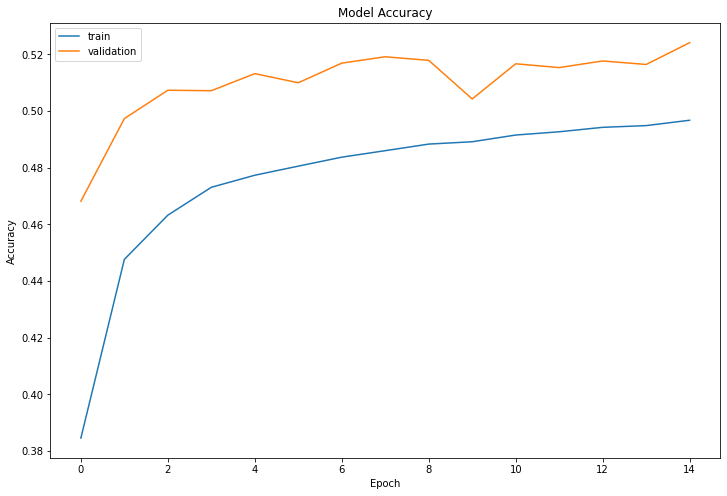

In [ ]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')

###Test

In [ ]:
conv_model.load_weights(checkpoint_filepath)

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(64)
conv_model.evaluate(test_dataset)

5625/5625 [==============================] - 21s 3ms/step - loss: 1.0985 - accuracy: 0.5452


[1.0985443592071533, 0.5452389121055603]

In [ ]:
Y_pred = conv_model.predict(test_dataset)

In [ ]:
Y_pred = np.argmax(Y_pred, axis=1)

In [ ]:
y_test = np.argmax(y_test, axis=1)

In [ ]:
target_names = ["8PSK",
     "AM-DSB",
     "AM-SSB",
     "BPSK",
     "CPFSK",
     "GFSK",
     "PAM4",
     "QAM16",
     "QAM64",
     "QPSK",
     "WBFM"]

<Figure size 1080x1080 with 0 Axes>

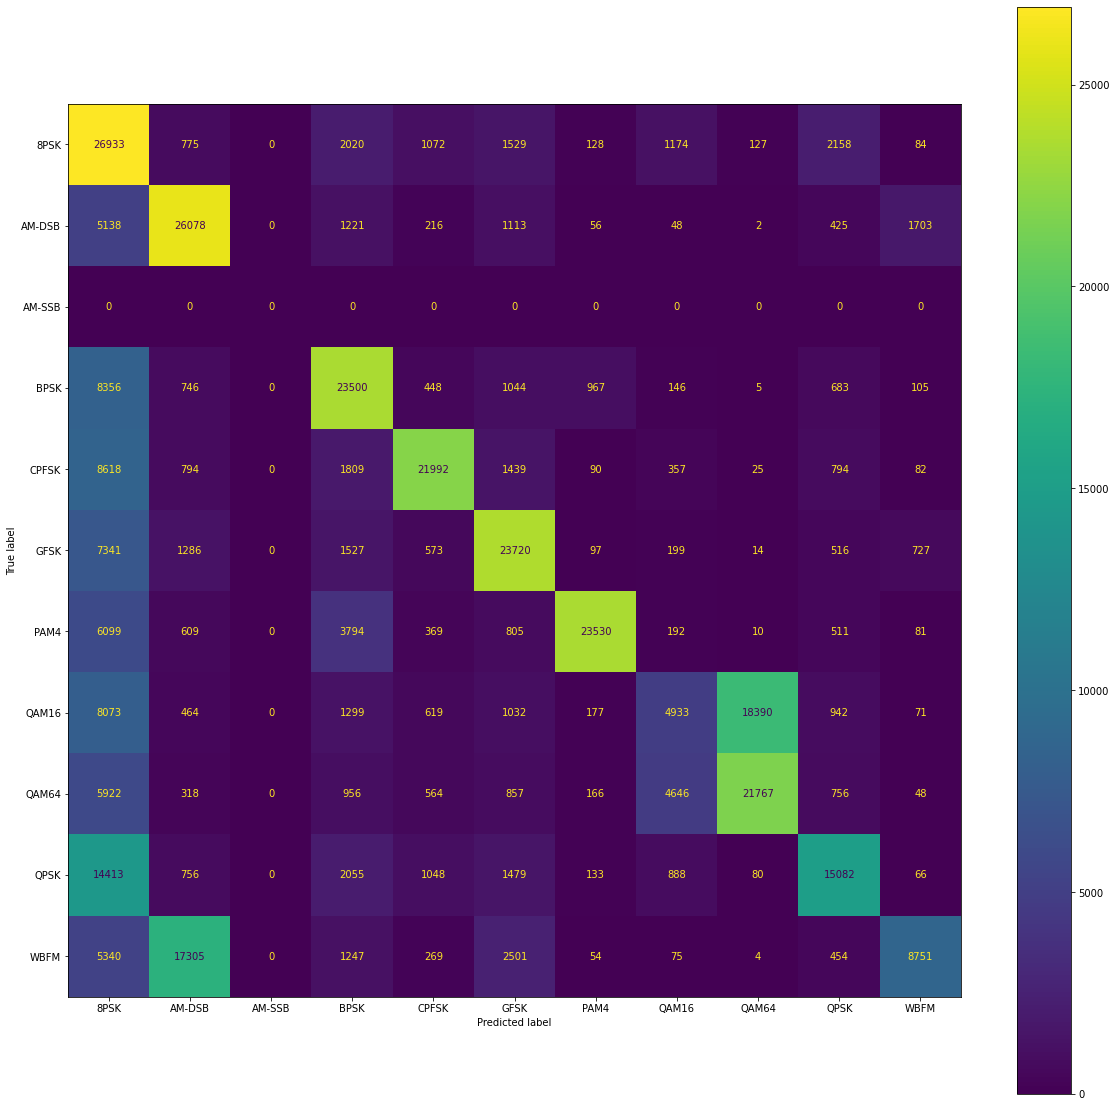

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, Y_pred,labels=[0,1,2,3,4,5,6,7,8,9,10]),
                              display_labels=target_names)
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(15)

# disp = disp.plot()

fig, ax = plt.subplots(figsize=(20,20))
disp.plot(ax=ax)


plt.show()

In [ ]:
print(y_test)

[[0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


In [ ]:
#SNR
for j in range(-20, 21 ):
  X_SNR = []
  y_Label = []
  for i in range(len(y_test)):
    if SNR_test[i] == j:
      X_SNR.append(X_test[i])
      y_Label.append(y_test[i])
  if len(X_SNR) != 0:
    print("SNR" + str(j))
    X_SNR = np.array(X_SNR)
    y_Label = np.array(y_Label)
    test_dataset = tf.data.Dataset.from_tensor_slices((X_SNR, y_Label)).batch(64)
    conv_model.evaluate(test_dataset)

SNR-20
282/282 [==============================] - 11s 4ms/step - loss: 2.3722 - accuracy: 0.1023
SNR-18
282/282 [==============================] - 1s 3ms/step - loss: 2.3612 - accuracy: 0.1018
SNR-16
282/282 [==============================] - 1s 4ms/step - loss: 2.3344 - accuracy: 0.1109
SNR-14
282/282 [==============================] - 1s 3ms/step - loss: 2.2751 - accuracy: 0.1221
SNR-12
282/282 [==============================] - 1s 3ms/step - loss: 2.1728 - accuracy: 0.1428
SNR-10
282/282 [==============================] - 1s 3ms/step - loss: 1.9370 - accuracy: 0.2278
SNR-8
282/282 [==============================] - 1s 3ms/step - loss: 1.6375 - accuracy: 0.3576
SNR-6
282/282 [==============================] - 1s 3ms/step - loss: 1.3208 - accuracy: 0.4989
SNR-4
282/282 [==============================] - 1s 3ms/step - loss: 0.9538 - accuracy: 0.6043
SNR-2
282/282 [==============================] - 1s 3ms/step - loss: 0.6789 - accuracy: 0.6845
SNR0
282/282 [=============================

##CNN Hyperparameter Tuning 

In [ ]:
X_vtrain = np.array(X_vtrain)
X_vval = np.array(X_vval)

In [ ]:
y_vval , SNR_vval = split_y(y_vval)
y_vval = map(mapper,y_vval)
y_vval = list(y_vval)
y_vval = np.array(y_vval)
temp4 = np.zeros((y_vval.size, 11))
temp4[np.arange(y_vval.size),y_vval] = 1
y_vval = temp4

y_vtrain , SNR_vtrain = split_y(y_vtrain)
y_vtrain = map(mapper,y_vtrain)
y_vtrain = list(y_vtrain)
y_vtrain = np.array(y_vtrain)
temp5 = np.zeros((y_vtrain.size, 11))
temp5[np.arange(y_vtrain.size),y_vtrain] = 1
y_vtrain = temp5

In [ ]:
del(y_vval)
del(y_vtrain)
del(X_vtrain)
del(X_vval)

In [ ]:
del(train_dataset)
del(validation_dataset)

In [ ]:
# del(history)
del(conv_model)

In [ ]:
conv_model = convolutional_model((4, 129, 1))
conv_model.compile(optimizer= keras.optimizers.Adam(learning_rate = 0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
# conv_model.compile(loss='categorical_crossentropy',
#     optimizer=tf.keras.optimizers.RMSprop(),metrics=['accuracy'])

conv_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 4, 129, 1)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 127, 64)        256       
                                                                 
 conv2d_9 (Conv2D)           (None, 3, 125, 16)        6160      
                                                                 
 batch_normalization_4 (Batc  (None, 3, 125, 16)       64        
 hNormalization)                                                 
                                                                 
 flatten_4 (Flatten)         (None, 6000)              0         
                                                                 
 dense_8 (Dense)             (None, 128)               768128    
                                                           

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_vtrain, y_vtrain)).batch(64)
validation_dataset = tf.data.Dataset.from_tensor_slices((X_vval, y_vval)).batch(64)

In [ ]:
history = conv_model.fit(train_dataset, epochs=20, validation_data=validation_dataset)

Epoch 1/20
624/624 [==============================] - 4s 6ms/step - loss: 2.1184 - accuracy: 0.2075 - val_loss: 1.9622 - val_accuracy: 0.2624
Epoch 2/20
624/624 [==============================] - 4s 6ms/step - loss: 1.9209 - accuracy: 0.2638 - val_loss: 1.7969 - val_accuracy: 0.2871
Epoch 3/20
624/624 [==============================] - 3s 6ms/step - loss: 1.8144 - accuracy: 0.2989 - val_loss: 1.6972 - val_accuracy: 0.3219
Epoch 4/20
624/624 [==============================] - 4s 6ms/step - loss: 1.7202 - accuracy: 0.3317 - val_loss: 1.6191 - val_accuracy: 0.3410
Epoch 5/20
624/624 [==============================] - 3s 5ms/step - loss: 1.6387 - accuracy: 0.3654 - val_loss: 1.5659 - val_accuracy: 0.3657
Epoch 6/20
624/624 [==============================] - 4s 6ms/step - loss: 1.5714 - accuracy: 0.3868 - val_loss: 1.5249 - val_accuracy: 0.3781
Epoch 7/20
624/624 [==============================] - 4s 6ms/step - loss: 1.5109 - accuracy: 0.4095 - val_loss: 1.4913 - val_accuracy: 0.3962
Epoch 

# Vanilla RNN


In [ ]:
def rnn_model(input_shape):

    model = keras.Sequential()
    model.add(layers.SimpleRNN(20,input_shape=input_shape))
    model.add(layers.Dense(11, activation='softmax'))
    return model

In [ ]:
rnn_model = rnn_model((4, 129))
rnn_model.compile(optimizer= keras.optimizers.Adam(learning_rate = 0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 20)                3000      
                                                                 
 dense (Dense)               (None, 11)                231       
                                                                 
Total params: 3,231
Trainable params: 3,231
Non-trainable params: 0
_________________________________________________________________


In [ ]:
del(train_dataset)
del(validation_dataset)

In [ ]:
train_dataset2 = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64)
validation_dataset2 = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(64)

In [ ]:
del(X_train)
del(y_train)
del(X_val)
del(y_val)

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/Pattern/Lab 4/Vanilla RNN checkpoints/checkpoint6'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
history = rnn_model.fit(train_dataset2, epochs=15, validation_data=validation_dataset2,callbacks=[model_checkpoint_callback])

In [ ]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/Pattern/Lab 4/Vanilla RNN checkpoints/checkpoint3'

In [ ]:
rnn_model.load_weights(checkpoint_filepath)

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(64)
rnn_model.evaluate(test_dataset)

5625/5625 [==============================] - 14s 2ms/step - loss: 1.5591 - accuracy: 0.3598


[1.5591039657592773, 0.3598083257675171]

In [ ]:
Y_pred = rnn_model.predict(test_dataset)

In [ ]:
Y_pred = np.argmax(Y_pred, axis=1)

In [ ]:
y_test = np.argmax(y_test, axis=1)

In [ ]:
target_names = ["8PSK",
     "AM-DSB",
     "AM-SSB",
     "BPSK",
     "CPFSK",
     "GFSK",
     "PAM4",
     "QAM16",
     "QAM64",
     "QPSK",
     "WBFM"]

<Figure size 1080x1080 with 0 Axes>

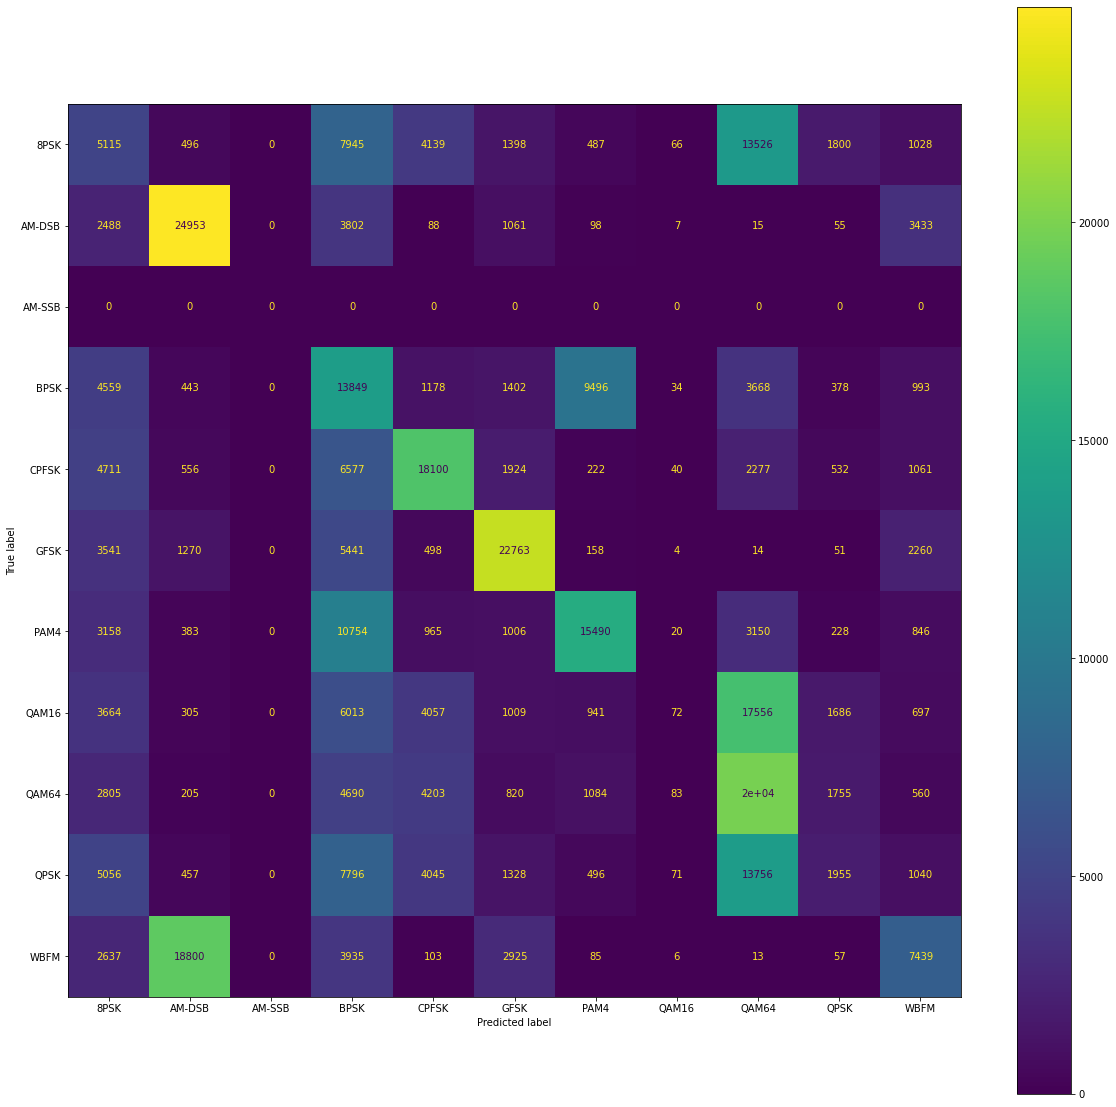

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, Y_pred,labels=[0,1,2,3,4,5,6,7,8,9,10]),
                              display_labels=target_names)
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(15)

# disp = disp.plot()

fig, ax = plt.subplots(figsize=(20,20))
disp.plot(ax=ax)


plt.show()

In [ ]:
#SNR
for j in range(-20, 21 ):
  X_SNR = []
  y_Label = []
  for i in range(len(y_test)):
    if SNR_test[i] == j:
      X_SNR.append(X_test[i])
      y_Label.append(y_test[i])
  if len(X_SNR) != 0:
    print("SNR" + str(j))
    X_SNR = np.array(X_SNR)
    y_Label = np.array(y_Label)
    test_dataset = tf.data.Dataset.from_tensor_slices((X_SNR, y_Label)).batch(64)
    rnn_model.evaluate(test_dataset)

SNR-20
282/282 [==============================] - 2s 2ms/step - loss: 2.3603 - accuracy: 0.1019
SNR-18
282/282 [==============================] - 1s 2ms/step - loss: 2.3480 - accuracy: 0.1038
SNR-16
282/282 [==============================] - 1s 2ms/step - loss: 2.3151 - accuracy: 0.1131
SNR-14
282/282 [==============================] - 1s 2ms/step - loss: 2.2562 - accuracy: 0.1290
SNR-12
282/282 [==============================] - 1s 2ms/step - loss: 2.1556 - accuracy: 0.1671
SNR-10
282/282 [==============================] - 1s 2ms/step - loss: 1.9922 - accuracy: 0.2379
SNR-8
282/282 [==============================] - 1s 2ms/step - loss: 1.8077 - accuracy: 0.2987
SNR-6
282/282 [==============================] - 1s 2ms/step - loss: 1.6429 - accuracy: 0.3642
SNR-4
282/282 [==============================] - 1s 2ms/step - loss: 1.4554 - accuracy: 0.4206
SNR-2
282/282 [==============================] - 1s 2ms/step - loss: 1.2868 - accuracy: 0.4534
SNR0
282/282 [==============================

# RNN Tuning

In [ ]:
rnn_model = rnn_model((4, 129))
rnn_model.compile(optimizer= keras.optimizers.Adam(learning_rate = 0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

rnn_model.summary()

In [ ]:
X_train_hyper, X_val_hyper, y_train_hyper, y_val_hyper = train_test_split(X_val, y_val, test_size=0.05,random_state=5,stratify=y_val)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_hyper, y_train_hyper)).batch(64)
validation_dataset = tf.data.Dataset.from_tensor_slices((X_val_hyper, y_val_hyper)).batch(64)

In [ ]:
history = rnn_model.fit(train_dataset, epochs=15, validation_data=validation_dataset)

# LSTM Model


In [ ]:
def LSTM_model(input_shape):
  lstm = Sequential();
  lstm.add(tfl.LSTM(input_shape[1], return_sequences=True, input_shape=input_shape))
  lstm.add(tfl.LSTM(10))
  lstm.add(Dense(11, activation='softmax'))
  lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[metrics.categorical_accuracy])
  return lstm

**hyper parameter tunning**

In [ ]:
LR = [1e-1, 1e-2, 1e-3, 1e-4]

In [ ]:
lstm = LSTM_model((4,129))
lstm.compile(optimizer= keras.optimizers.Adam(learning_rate = LR[2]),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64)
validation_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(64)

ValueError: ignored

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/Pattern/Lab 4/LSTM checkpoints/checkpoint_derivative_integration'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
history = lstm.fit(X_train,y_train,epochs=15,validation_data=(X_val, y_val),callbacks=[model_checkpoint_callback]) #,callbacks=[model_checkpoint_callback]

In [ ]:
history = lstm.fit(train_dataset,epochs=15,validation_data=validation_dataset,callbacks=[model_checkpoint_callback]) #,callbacks=[model_checkpoint_callback]

Epoch 1/15
12469/12469 [==============================] - 81s 6ms/step - loss: 1.8421 - accuracy: 0.2708 - val_loss: 1.7120 - val_accuracy: 0.3240
Epoch 2/15
12469/12469 [==============================] - 70s 6ms/step - loss: 1.6310 - accuracy: 0.3532 - val_loss: 1.5617 - val_accuracy: 0.3689
Epoch 3/15
12469/12469 [==============================] - 69s 6ms/step - loss: 1.5200 - accuracy: 0.3795 - val_loss: 1.4985 - val_accuracy: 0.3821
Epoch 4/15
12469/12469 [==============================] - 69s 6ms/step - loss: 1.4717 - accuracy: 0.3907 - val_loss: 1.4626 - val_accuracy: 0.3924
Epoch 5/15
12469/12469 [==============================] - 69s 6ms/step - loss: 1.4321 - accuracy: 0.4003 - val_loss: 1.4272 - val_accuracy: 0.4004
Epoch 6/15
12469/12469 [==============================] - 70s 6ms/step - loss: 1.3927 - accuracy: 0.4112 - val_loss: 1.3939 - val_accuracy: 0.4098
Epoch 7/15
12469/12469 [==============================] - 69s 6ms/step - loss: 1.3601 - accuracy: 0.4210 - val_loss: 1

In [ ]:
lstm.load_weights(checkpoint_filepath)

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(64)
lstm.evaluate(test_dataset)

5625/5625 [==============================] - 22s 4ms/step - loss: 1.1639 - accuracy: 0.5153


[1.1638702154159546, 0.515280544757843]

In [ ]:
#SNR lstm
for j in range(-20, 21 ):
  X_SNR = []
  y_Label = []
  for i in range(len(y_test)):
    if SNR_test[i] == j:
      X_SNR.append(X_test[i])
      y_Label.append(y_test[i])
  if len(X_SNR) != 0:
    print("SNR" + str(j))
    X_SNR = np.array(X_SNR)
    y_Label = np.array(y_Label)
    test_dataset = tf.data.Dataset.from_tensor_slices((X_SNR, y_Label)).batch(64)
    lstm.evaluate(test_dataset)

SNR-20
282/282 [==============================] - 7s 4ms/step - loss: 2.3784 - accuracy: 0.1029
SNR-18
282/282 [==============================] - 1s 4ms/step - loss: 2.3670 - accuracy: 0.1064
SNR-16
282/282 [==============================] - 1s 4ms/step - loss: 2.3166 - accuracy: 0.1157
SNR-14
282/282 [==============================] - 1s 4ms/step - loss: 2.2472 - accuracy: 0.1325
SNR-12
282/282 [==============================] - 1s 4ms/step - loss: 2.1182 - accuracy: 0.1909
SNR-10
282/282 [==============================] - 1s 4ms/step - loss: 1.9031 - accuracy: 0.2894
SNR-8
282/282 [==============================] - 1s 4ms/step - loss: 1.6306 - accuracy: 0.3673
SNR-6
282/282 [==============================] - 1s 4ms/step - loss: 1.3416 - accuracy: 0.4523
SNR-4
282/282 [==============================] - 1s 4ms/step - loss: 1.0410 - accuracy: 0.5440
SNR-2
282/282 [==============================] - 1s 4ms/step - loss: 0.8182 - accuracy: 0.6296
SNR0
282/282 [==============================

In [ ]:
Y_pred = lstm.predict(test_dataset)

In [ ]:
Y_pred = np.argmax(Y_pred, axis=1)

In [ ]:
y_test = np.argmax(y_test, axis=1)

In [ ]:
target_names = ["8PSK",
     "AM-DSB",
     "AM-SSB",
     "BPSK",
     "CPFSK",
     "GFSK",
     "PAM4",
     "QAM16",
     "QAM64",
     "QPSK",
     "WBFM"]

<Figure size 1080x1080 with 0 Axes>

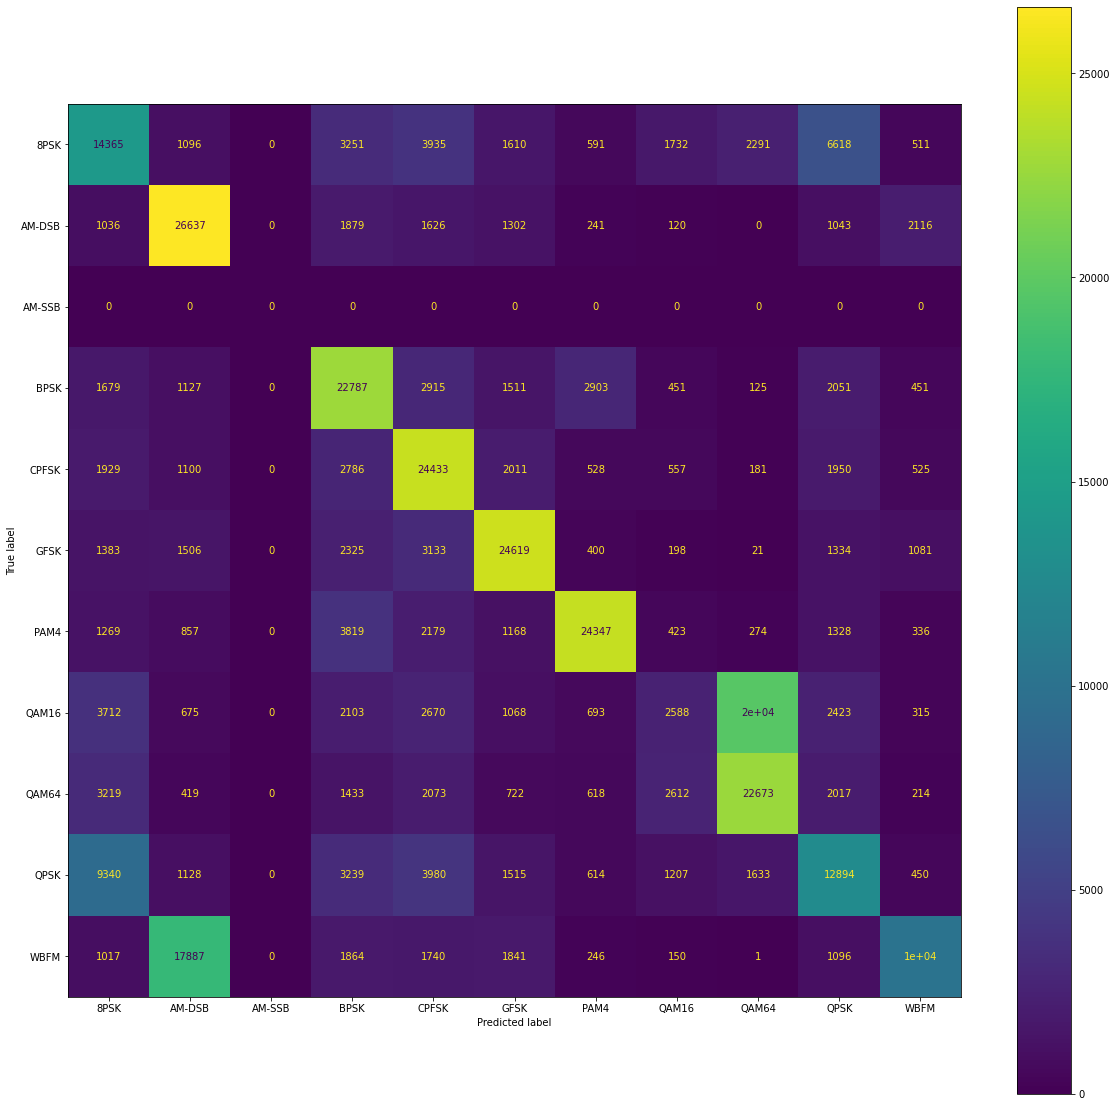

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, Y_pred,labels=[0,1,2,3,4,5,6,7,8,9,10]),
                              display_labels=target_names)
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(15)

# disp = disp.plot()

fig, ax = plt.subplots(figsize=(20,20))
disp.plot(ax=ax)


plt.show()

In [ ]:
import pandas as pd

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Epoch')]

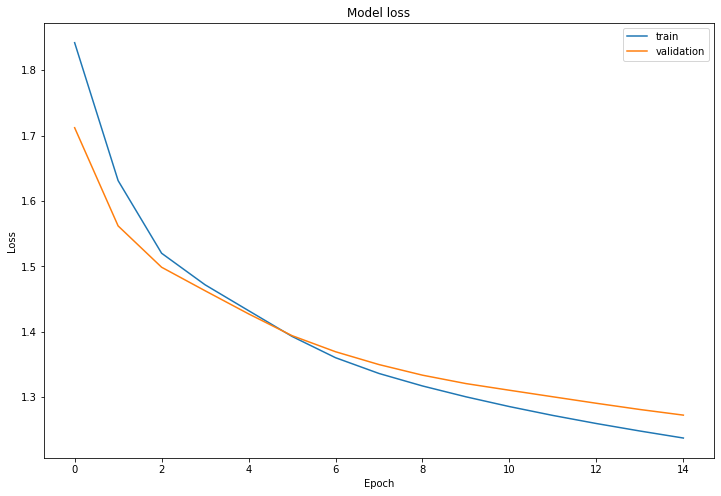

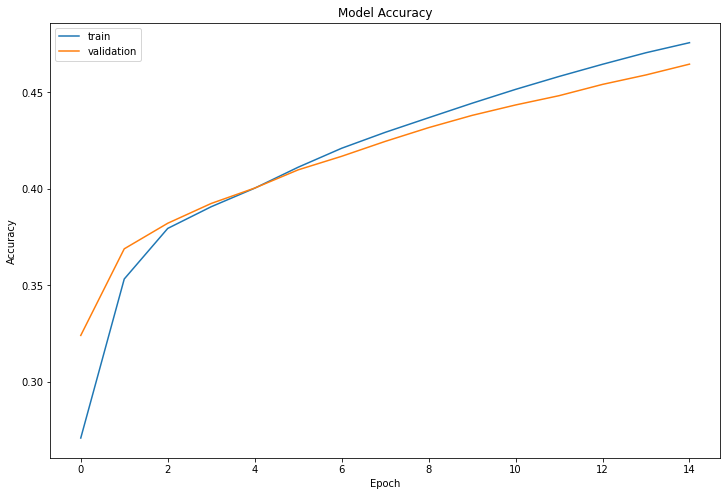

In [ ]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')